In [5]:
# Paths
input_dir = "../data/chapters"

import re
import os
def chapter_number(filename):
    # Extract first number from filename (e.g., "chapter_10_nostopwords.txt" -> 10)
    match = re.search(r"(\d+)", filename)
    return int(match.group(1)) if match else 0

files = sorted(
    [f for f in os.listdir(input_dir) if f.endswith(".txt")],
    key=chapter_number
)


In [6]:
chapters = []
chapter_names = []

for f in files:
    with open(os.path.join(input_dir, f), "r", encoding="utf-8") as infile:
        text = infile.read()
        chapters.append(text)
        chapter_names.append(f)

In [8]:
%pip install spacy
%pip install scikit-learn
!python -m spacy download en_core_web_sm
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ 
        for token in doc 
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

processed_chapters = [preprocess(ch) for ch in chapters]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag-of-Words
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X_bow = vectorizer.fit_transform(processed_chapters)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(processed_chapters)

In [63]:
# --- Function to Display Top Words ---
def display_top_words(X, vectorizer, n_top_words=10):

    sum_words = X.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    top_words_df = pd.DataFrame(words_freq[:n_top_words], columns=['Word', 'Score'])
    
    return top_words_df

# --- Get and Display the Results ---

print("--- Top words from Bag-of-Words (by frequency) ---")
top_bow_df = display_top_words(X_bow, vectorizer, 10)
print(top_bow_df)

print("\n--- Top words from TF-IDF (by aggregate score) ---")
top_tfidf_df = display_top_words(X_tfidf, tfidf_vectorizer, 10)
print(top_tfidf_df)


--- Top words from Bag-of-Words (by frequency) ---
      Word  Score
0   lawyer    260
1    court    169
2  painter    141
3    judge    130
4     work    121
5     need    114
6    trial    111
7     miss    110
8    speak    107
9   office    105

--- Top words from TF-IDF (by aggregate score) ---
         Word     Score
0      lawyer  1.222517
1        miss  0.959190
2       uncle  0.784250
3   policeman  0.777459
4  doorkeeper  0.768118
5     painter  0.756635
6   gentleman  0.734959
7    bürstner  0.723068
8         mrs  0.717178
9     grubach  0.717178


In [49]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3  # adjust 3–6
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda.fit(X_bow)

,n_components,3
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [54]:
import numpy as np

words = vectorizer.get_feature_names_out()

def print_topics(model, n_words=5):
    for idx, topic in enumerate(model.components_):
        top_words = [words[i] for i in topic.argsort()[-n_words:]]
        print(f"Topic {idx}: {', '.join(top_words)}")

print_topics(lda)

Topic 0: trial, lawyer, judge, painter, court
Topic 1: mrs, grubach, bürstner, uncle, miss
Topic 2: speak, block, leni, businessman, lawyer


In [55]:
import pandas as pd

doc_topic_dist = lda.transform(X_bow)

df_topics = pd.DataFrame(
    doc_topic_dist,
    columns=[f"Topic {i}" for i in range(n_topics)]
)
df_topics["chapter"] = chapter_names

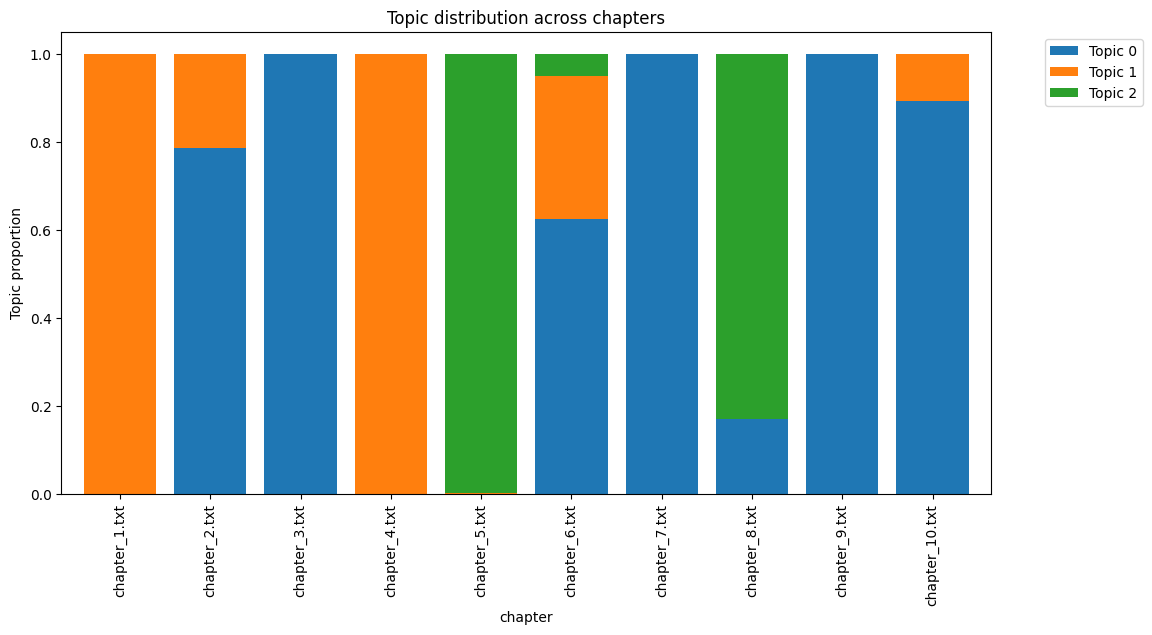

In [56]:
import matplotlib.pyplot as plt

df_topics.set_index("chapter").plot(
    kind="bar", stacked=True, figsize=(12,6), width=0.8
)
plt.ylabel("Topic proportion")
plt.title("Topic distribution across chapters")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()